Train samples: 400
Validation samples: 100
Test (0.2 noise) samples: 500
Using device: cuda

Training Model 1: MLP + Early Stopping
Model 1 training complete.

Training Model 2: MLP + L1 Regularization
Best L1 Lambda: 1e-06
L1 Grid Search Results:
     lambda  val_auroc  sparsity_layer1  sparse_count_layer1  sparsity_layer2  \
0  0.000001   0.995974         0.000000                    0         0.000000   
1  0.000003   0.995974         0.007812                    1         0.015625   
2  0.000010   0.995974         0.007812                    1         0.031250   
3  0.000030   0.995974         0.046875                    6         0.062500   
4  0.000100   0.995974         0.078125                   10         0.093750   
5  0.000300   0.995974         0.132812                   17         0.250000   

   sparse_count_layer2  sparsity_total  sparse_count_total  
0                    0        0.000000                   0  
1                    1        0.010417                   2  
2

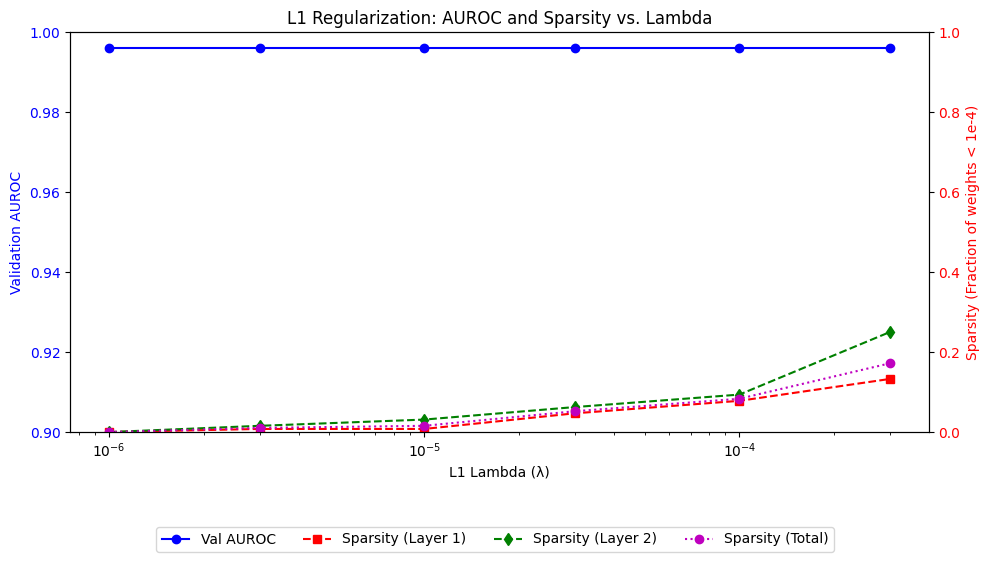

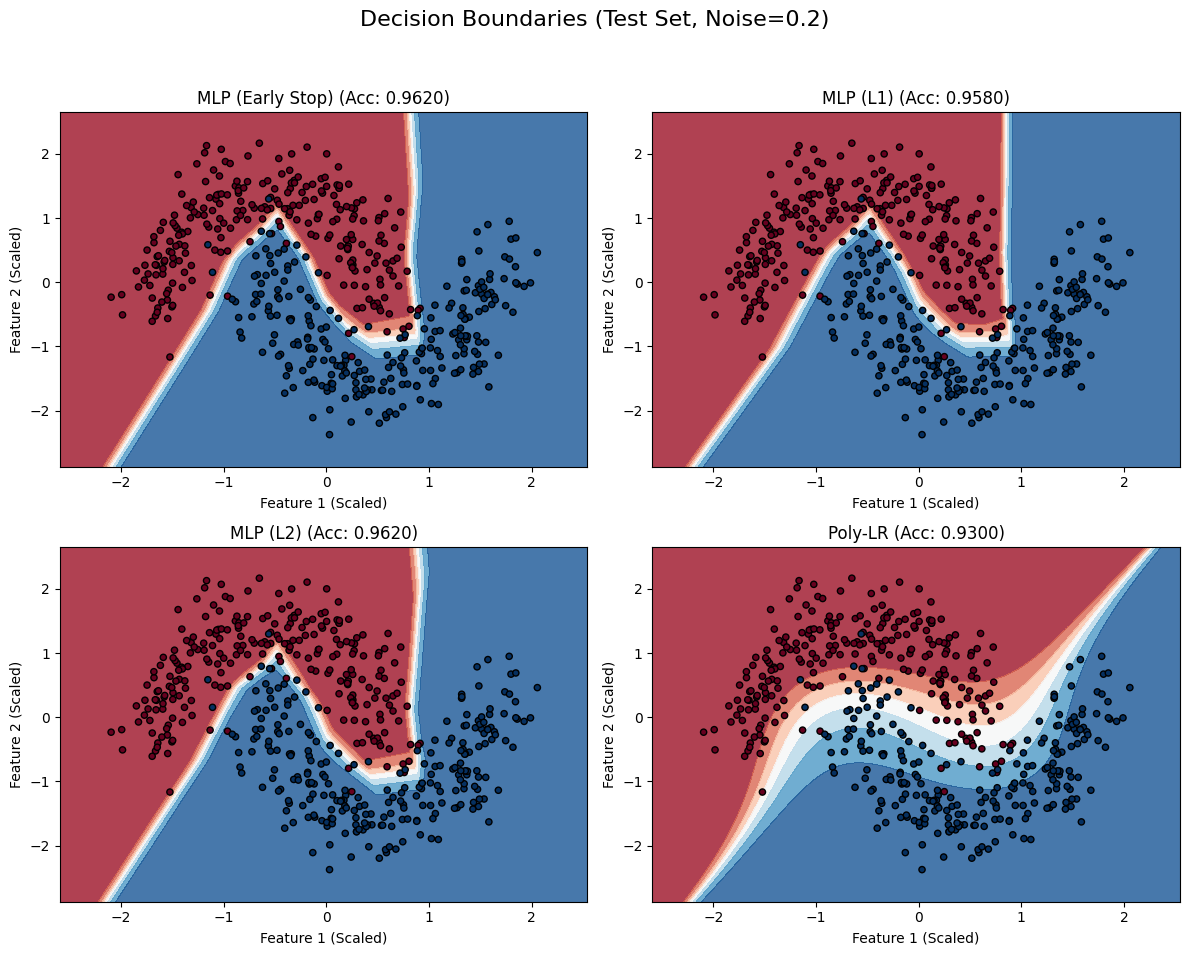

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import pandas as pd
import copy

# Set random seeds for reproducibility
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 1. Custom Make-Moons Dataset Generation

def custom_make_moons(n_samples=100, noise=0.0, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    t_out = np.linspace(0, np.pi, n_samples_out)
    x_out = np.cos(t_out)
    y_out = np.sin(t_out)
    t_in = np.linspace(0, np.pi, n_samples_in)
    x_in = 1 - np.cos(t_in)
    y_in = 0.5 - np.sin(t_in)
    X = np.vstack([np.column_stack([x_out, y_out]),
                   np.column_stack([x_in, y_in])])
    y = np.hstack([np.zeros(n_samples_out), np.ones(n_samples_in)])
    if noise > 0:
        X += np.random.normal(scale=noise, size=X.shape)
    return X, y

# 2. Data Generation and Splitting
X_train_full, y_train_full = custom_make_moons(n_samples=500, noise=0.2, random_state=SEED)
X_test_02, y_test_02 = custom_make_moons(n_samples=500, noise=0.2, random_state=SEED + 1)
X_test_01, y_test_01 = custom_make_moons(n_samples=500, noise=0.1, random_state=SEED + 2)
X_test_03, y_test_03 = custom_make_moons(n_samples=500, noise=0.3, random_state=SEED + 3)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=SEED
)
print(f"Train samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test (0.2 noise) samples: {X_test_02.shape[0]}")

# 3. Standardization

train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
epsilon = 1e-8
X_train_scaled = (X_train - train_mean) / (train_std + epsilon)
X_val_scaled = (X_val - train_mean) / (train_std + epsilon)
X_test_02_scaled = (X_test_02 - train_mean) / (train_std + epsilon)
X_test_01_scaled = (X_test_01 - train_mean) / (train_std + epsilon)
X_test_03_scaled = (X_test_03 - train_mean) / (train_std + epsilon)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test_01_t = torch.tensor(X_test_01_scaled, dtype=torch.float32).to(device)
X_test_02_t = torch.tensor(X_test_02_scaled, dtype=torch.float32).to(device)
X_test_03_t = torch.tensor(X_test_03_scaled, dtype=torch.float32).to(device)
y_test_01_t = torch.tensor(y_test_01, dtype=torch.float32).view(-1, 1).to(device)
y_test_02_t = torch.tensor(y_test_02, dtype=torch.float32).view(-1, 1).to(device)
y_test_03_t = torch.tensor(y_test_03, dtype=torch.float32).view(-1, 1).to(device)


#  MLP Model and Helper Functions

class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=1):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

class LogisticRegressionModel(nn.Module):
    def __init__(self, num_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(num_features, 1) # One layer

    def forward(self, x):
        # It just passes the input through the linear layer
        # The nn.BCEWithLogitsLoss will handle the sigmoid activation.
        return self.linear(x)

def get_param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, X_test_t, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
    accuracy = accuracy_score(y_test, preds)
    auroc = roc_auc_score(y_test, probs)
    return accuracy, auroc

# Training loop with early stopping
def train_with_early_stopping(model, X_train_t, y_train_t, X_val_t, y_val_t,
                              optimizer, criterion,
                              epochs=1000, patience=50,
                              l1_lambda=0, l2_lambda=0):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    for epoch in range(epochs):
        model.train()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        if l1_lambda > 0:
            l1_penalty = 0
            for param in model.parameters():
                l1_penalty += torch.abs(param).sum()
            loss += l1_lambda * l1_penalty
        if l2_lambda > 0:
            l2_penalty = 0
            for param in model.parameters():
                l2_penalty += param.pow(2).sum()
            loss += l2_lambda * l2_penalty
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            val_loss = criterion(val_logits, y_val_t)
            if l1_lambda > 0:
                l1_penalty_val = 0
                for param in model.parameters():
                    l1_penalty_val += torch.abs(param).sum()
                val_loss += l1_lambda * l1_penalty_val
            if l2_lambda > 0:
                l2_penalty_val = 0
                for param in model.parameters():
                    l2_penalty_val += param.pow(2).sum()
                val_loss += l2_lambda * l2_penalty_val
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            break
    model.load_state_dict(best_model_weights)
    return model

# --- 6. Model 1: MLP with Early Stopping ---
print("\nTraining Model 1: MLP + Early Stopping")
model_es = MLP().to(device)
optimizer_es = optim.Adam(model_es.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
model_es = train_with_early_stopping(
    model_es, X_train_t, y_train_t, X_val_t, y_val_t,
    optimizer_es, criterion, patience=50
)
print("Model 1 training complete.")
param_count_es = get_param_count(model_es)


print("\nTraining Model 2: MLP + L1 Regularization")
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
l1_models = {}

def get_sparsity(model, threshold=1e-4):
    """
    Computes sparsity information layerwise and overall.
    A weight is 'sparse' if |w| < threshold.
    """
    layer_sparsity = {}
    total_weights = 0
    total_sparse = 0

    for name, param in model.named_parameters():
        if 'weight' in name:  # skip biases
            weights = param.data.cpu().numpy()
            num_weights = weights.size
            num_sparse = np.sum(np.abs(weights) < threshold)
            sparsity_ratio = num_sparse / num_weights

            layer_sparsity[name] = {
                'sparse_count': int(num_sparse),
                'total_count': int(num_weights),
                'sparsity_ratio': sparsity_ratio
            }

            total_weights += num_weights
            total_sparse += num_sparse

    layer_sparsity['total'] = {
        'sparse_count': int(total_sparse),
        'total_count': int(total_weights),
        'sparsity_ratio': total_sparse / total_weights
    }

    return layer_sparsity


for l1_lambda in l1_lambdas:
    model_l1_grid = MLP().to(device)
    optimizer_l1 = optim.Adam(model_l1_grid.parameters(), lr=0.01)

    model_l1_grid = train_with_early_stopping(
        model_l1_grid, X_train_t, y_train_t, X_val_t, y_val_t,
        optimizer_l1, criterion, patience=50, l1_lambda=l1_lambda
    )

    _, val_auroc = evaluate_model(model_l1_grid, X_val_t, y_val)
    sparsity = get_sparsity(model_l1_grid)

    l1_results.append({
    'lambda': l1_lambda,
    'val_auroc': val_auroc,

    # Layerwise sparsity ratios
    'sparsity_layer1': sparsity['layer1.weight']['sparsity_ratio'],
    'sparse_count_layer1': sparsity['layer1.weight']['sparse_count'],
    'sparsity_layer2': sparsity['layer2.weight']['sparsity_ratio'],
    'sparse_count_layer2': sparsity['layer2.weight']['sparse_count'],
    'sparsity_total': sparsity['total']['sparsity_ratio'],
    'sparse_count_total': sparsity['total']['sparse_count'],
})
    l1_models[l1_lambda] = model_l1_grid

l1_results_df = pd.DataFrame(l1_results)
best_l1_lambda = l1_results_df.loc[l1_results_df['val_auroc'].idxmax()]['lambda']
model_l1 = l1_models[best_l1_lambda]


print(f"Best L1 Lambda: {best_l1_lambda}")
print("L1 Grid Search Results:")
print(l1_results_df)

param_count_l1 = get_param_count(model_l1)

# Plot L1 results
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda (λ)')
ax1.set_ylabel('Validation AUROC', color='blue')
ax1.plot(l1_results_df['lambda'], l1_results_df['val_auroc'], 'bo-', label='Val AUROC')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.9, 1.0)

ax2 = ax1.twinx()
ax2.set_ylabel('Sparsity (Fraction of weights < 1e-4)', color='red')
ax2.plot(l1_results_df['lambda'], l1_results_df['sparsity_layer1'], 'rs--', label='Sparsity (Layer 1)')
ax2.plot(l1_results_df['lambda'], l1_results_df['sparsity_layer2'], 'gd--', label='Sparsity (Layer 2)')
ax2.plot(l1_results_df['lambda'], l1_results_df['sparsity_total'], 'm:o', label='Sparsity (Total)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1.0)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.title('L1 Regularization: AUROC and Sparsity vs. Lambda')
fig.tight_layout()
plt.savefig("l1_regularization_plot.png", bbox_inches='tight')
print("Saved L1 sparsity/AUROC plot to l1_regularization_plot.png")


#  Model 3: MLP with L2 Regularization
print("\nTraining Model 3: MLP + L2 Regularization")
l2_decays = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l2_results = []
l2_models = {}
for l2_decay in l2_decays:
    model_l2_grid = MLP().to(device)
    optimizer_l2 = optim.Adam(model_l2_grid.parameters(), lr=0.01)
    model_l2_grid = train_with_early_stopping(
        model_l2_grid, X_train_t, y_train_t, X_val_t, y_val_t,
        optimizer_l2, criterion, patience=50, l2_lambda=l2_decay
    )
    _, val_auroc = evaluate_model(model_l2_grid, X_val_t, y_val)
    l2_results.append({'weight_decay': l2_decay, 'val_auroc': val_auroc})
    l2_models[l2_decay] = model_l2_grid
l2_results_df = pd.DataFrame(l2_results)
best_l2_decay = l2_results_df.loc[l2_results_df['val_auroc'].idxmax()]['weight_decay']
model_l2 = l2_models[best_l2_decay]
print(f"Best L2 Lambda (from manual): {best_l2_decay}")
print("L2 Grid Search Results:")
print(l2_results_df)
param_count_l2 = get_param_count(model_l2)

#  Model 4: Logistic Regression

print("\nTraining Model 4: Polynomial Logistic Regression")
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_val_poly_scaled = scaler_poly.transform(X_val_poly)

print(f"Poly-LR features: {X_train_poly_scaled.shape[1]}")
X_train_poly_t = torch.tensor(X_train_poly_scaled, dtype=torch.float32).to(device)
X_val_poly_t = torch.tensor(X_val_poly_scaled, dtype=torch.float32).to(device)
num_poly_features = X_train_poly_scaled.shape[1]
model_poly_lr = LogisticRegressionModel(num_poly_features).to(device)
optimizer_poly_lr = optim.Adam(model_poly_lr.parameters(), lr=0.01)
model_poly_lr = train_with_early_stopping(
    model_poly_lr, X_train_poly_t, y_train_t, X_val_poly_t, y_val_t,
    optimizer_poly_lr, criterion, patience=50,
    l1_lambda=0, l2_lambda=0
)

param_count_lr = get_param_count(model_poly_lr)
print(f"Poly-LR param count: {param_count_lr}")
X_test_01_poly_scaled = scaler_poly.transform(poly.transform(X_test_01_scaled))
X_test_02_poly_scaled = scaler_poly.transform(poly.transform(X_test_02_scaled))
X_test_03_poly_scaled = scaler_poly.transform(poly.transform(X_test_03_scaled))
X_test_01_poly_t = torch.tensor(X_test_01_poly_scaled, dtype=torch.float32).to(device)
X_test_02_poly_t = torch.tensor(X_test_02_poly_scaled, dtype=torch.float32).to(device)
X_test_03_poly_t = torch.tensor(X_test_03_poly_scaled, dtype=torch.float32).to(device)

# Evaluation and Analysis

print("\nEvaluation on Test Sets")

models = {
    'MLP (Early Stop)': model_es,
    'MLP (L1)': model_l1,
    'MLP (L2)': model_l2,
    'Poly-LR': model_poly_lr
}

param_counts = {
    'MLP (Early Stop)': param_count_es,
    'MLP (L1)': param_count_l1,
    'MLP (L2)': param_count_l2,
    'Poly-LR': param_count_lr
}

# Test data for MLPs (input is 2 features)
test_data_mlp = {
    'Test Acc (0.2 noise)': (X_test_02_t, y_test_02),
    'Test Acc (0.1 noise)': (X_test_01_t, y_test_01),
    'Test Acc (0.3 noise)': (X_test_03_t, y_test_03),
}

# Test data for new LR model (input is 9 polynomial features)
test_data_poly_lr = {
    'Test Acc (0.2 noise)': (X_test_02_poly_t, y_test_02),
    'Test Acc (0.1 noise)': (X_test_01_poly_t, y_test_01),
    'Test Acc (0.3 noise)': (X_test_03_poly_t, y_test_03),
}

results = []

for name, model in models.items():
    row = {'Model': name, 'Param Count': param_counts[name]}

    # Select the correct test dataset based on the model name
    if 'Poly-LR' in name:
        current_test_data = test_data_poly_lr
    else: # It's an MLP
        current_test_data = test_data_mlp
    for acc_name, (X_test_t, y_test) in current_test_data.items():
        acc, _ = evaluate_model(model, X_test_t, y_test)
        row[acc_name] = acc

    results.append(row)

results_df = pd.DataFrame(results)
print("Test Accuracy Table:")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

# 11. Plot Decision Boundaries (on noise=0.2 test set)

print("\nPlotting decision boundaries...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Decision Boundaries (Test Set, Noise=0.2)', fontsize=16)
X_plot = X_test_02_scaled
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_np = np.c_[xx.ravel(), yy.ravel()]
grid_t = torch.tensor(grid_np, dtype=torch.float32).to(device)
grid_poly_np = poly.transform(grid_np)
grid_poly_scaled_np = scaler_poly.transform(grid_poly_np)
grid_poly_t = torch.tensor(grid_poly_scaled_np, dtype=torch.float32).to(device)
for ax, (name, model) in zip(axes.ravel(), models.items()):
    model.eval()
    with torch.no_grad():
        if 'Poly-LR' in name:
            # Use the polynomial grid
            Z = torch.sigmoid(model(grid_poly_t)).cpu().numpy().reshape(xx.shape)
        else:
            # Use the 2-feature grid
            Z = torch.sigmoid(model(grid_t)).cpu().numpy().reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_test_02, s=20,
               edgecolor='k', cmap=plt.cm.RdBu)
    ax.set_title(f"{name} (Acc: {results_df[results_df['Model'] == name]['Test Acc (0.2 noise)'].values[0]:.4f})")
    ax.set_xlabel('Feature 1 (Scaled)')
    ax.set_ylabel('Feature 2 (Scaled)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("decision_boundaries.png")

# Class Imbalance
print(" Class Imbalance Experiment (70:30) ")
X_class_0 = X_train_full[y_train_full == 0]; y_class_0 = y_train_full[y_train_full == 0]
X_class_1 = X_train_full[y_train_full == 1]; y_class_1 = y_train_full[y_train_full == 1]
n_class_1_imb = int(len(X_class_0) * (3/7))
X_class_1_sub, _, y_class_1_sub, _ = train_test_split(
    X_class_1, y_class_1, train_size=n_class_1_imb, random_state=SEED
)
X_train_full_imb = np.vstack([X_class_0, X_class_1_sub])
y_train_full_imb = np.hstack([y_class_0, y_class_1_sub])
X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(
    X_train_full_imb, y_train_full_imb, test_size=0.2, random_state=SEED
)
scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)
X_val_imb_scaled = scaler_imb.transform(X_val_imb)
X_test_02_imb_scaled = scaler_imb.transform(X_test_02)
X_train_imb_t = torch.tensor(X_train_imb_scaled, dtype=torch.float32).to(device)
y_train_imb_t = torch.tensor(y_train_imb, dtype=torch.float32).view(-1, 1).to(device)
X_val_imb_t = torch.tensor(X_val_imb_scaled, dtype=torch.float32).to(device)
y_val_imb_t = torch.tensor(y_val_imb, dtype=torch.float32).view(-1, 1).to(device)
print(f"Imbalanced train samples: {X_train_imb_scaled.shape[0]}")
print(f"Imbalanced val samples: {X_val_imb_scaled.shape[0]}")
print(f"Balanced test samples: {X_test_02_imb_scaled.shape[0]}")

print("Retraining models on imbalanced data...")

# Model 1 (Imb): MLP + Early Stopping
model_es_imb = MLP().to(device)
optimizer_es_imb = optim.Adam(model_es_imb.parameters(), lr=0.01)
model_es_imb = train_with_early_stopping(
    model_es_imb, X_train_imb_t, y_train_imb_t, X_val_imb_t, y_val_imb_t,
    optimizer_es_imb, criterion, patience=50
)

#Model 2 (Imb): MLP + L1
best_val_auroc_l1_imb = -1
model_l1_imb = None
for l1_lambda in l1_lambdas:
    model_l1_grid_imb = MLP().to(device)
    optimizer_l1_imb = optim.Adam(model_l1_grid_imb.parameters(), lr=0.01)
    model_l1_grid_imb = train_with_early_stopping(
        model_l1_grid_imb, X_train_imb_t, y_train_imb_t, X_val_imb_t, y_val_imb_t,
        optimizer_l1_imb, criterion, patience=50, l1_lambda=l1_lambda
    )
    _, val_auroc = evaluate_model(model_l1_grid_imb, X_val_imb_t, y_val_imb)
    if val_auroc > best_val_auroc_l1_imb:
        best_val_auroc_l1_imb = val_auroc
        model_l1_imb = model_l1_grid_imb

#  Model 3 (Imb): MLP + L2
best_val_auroc_l2_imb = -1
model_l2_imb = None
for l2_decay in l2_decays:
    model_l2_grid_imb = MLP().to(device)
    optimizer_l2_imb = optim.Adam(model_l2_grid_imb.parameters(), lr=0.01)
    model_l2_grid_imb = train_with_early_stopping(
        model_l2_grid_imb, X_train_imb_t, y_train_imb_t, X_val_imb_t, y_val_imb_t,
        optimizer_l2_imb, criterion, patience=50, l2_lambda=l2_decay
    )
    _, val_auroc = evaluate_model(model_l2_grid_imb, X_val_imb_t, y_val_imb)
    if val_auroc > best_val_auroc_l2_imb:
        best_val_auroc_l2_imb = val_auroc
        model_l2_imb = model_l2_grid_imb

# Model 4 (Imb): Poly LR (From-Scratch)
poly_imb = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_imb = poly_imb.fit_transform(X_train_imb_scaled)
X_val_poly_imb = poly_imb.transform(X_val_imb_scaled)

scaler_poly_imb = StandardScaler()
X_train_poly_imb_scaled = scaler_poly_imb.fit_transform(X_train_poly_imb)
X_val_poly_imb_scaled = scaler_poly_imb.transform(X_val_poly_imb)
X_train_poly_imb_t = torch.tensor(X_train_poly_imb_scaled, dtype=torch.float32).to(device)
X_val_poly_imb_t = torch.tensor(X_val_poly_imb_scaled, dtype=torch.float32).to(device)

# Create and train the model
num_poly_features_imb = X_train_poly_imb_scaled.shape[1]
model_poly_lr_imb = LogisticRegressionModel(num_poly_features_imb).to(device)
optimizer_poly_lr_imb = optim.Adam(model_poly_lr_imb.parameters(), lr=0.01)

model_poly_lr_imb = train_with_early_stopping(
    model_poly_lr_imb, X_train_poly_imb_t, y_train_imb_t, X_val_poly_imb_t, y_val_imb_t,
    optimizer_poly_lr_imb, criterion, patience=50,
    l1_lambda=0, l2_lambda=0 # No regularization
)
models_imb = {
    'MLP (Early Stop)': model_es_imb,
    'MLP (L1)': model_l1_imb,
    'MLP (L2)': model_l2_imb,
    'Poly-LR (From-Scratch)': model_poly_lr_imb
}
X_test_02_imb_poly = poly_imb.transform(X_test_02_imb_scaled)
X_test_02_imb_poly_scaled = scaler_poly_imb.transform(X_test_02_imb_poly)
X_test_02_imb_poly_t = torch.tensor(X_test_02_imb_poly_scaled, dtype=torch.float32).to(device)

results_imb = []

for name, model in models_imb.items():
    if 'Poly-LR' in name:
        acc, auroc = evaluate_model(model, X_test_02_imb_poly_t, y_test_02)
    else:
        X_test_02_imb_t = torch.tensor(X_test_02_imb_scaled, dtype=torch.float32).to(device)
        acc, auroc = evaluate_model(model, X_test_02_imb_t, y_test_02)

    results_imb.append({
        'Model': name,
        'Test Accuracy': acc,
        'Test AUROC': auroc
    })

results_imb_df = pd.DataFrame(results_imb)
print("Imbalanced Training / Balanced Test Results:")
print(results_imb_df.to_markdown(index=False, floatfmt=".4f"))



### 1. Effect of L1 Regularization (Sparsity and Jaggedness)

L1 regularization penalizes the absolute value of weights($|w|$), which can force weights to become exactly zero. This is a form of feature selection that creates a "sparse" model.

* **Our Results:** The "L1 Regularization... vs. Lambda" plot confirms that as $\lambda$ increases, sparsity (the fraction of zeroed weights) also increases.
* **Decision Boundary:** By eliminating features, L1 can create simpler, sometimes "sharper" or "jagged" decision boundaries, as the model relies on fewer features. However, our "MLP (L1)" plot shows almost a *smooth* boundary, not a jagged one. The "L1 Grid Search Results" table explains why: the best $\lambda$ chosen was $10^{-6}$, which resulted in **zero sparsity**. Because the optimal $\lambda$ was so small, our final L1 model wasn't actually sparse, so its boundary remained almost smooth.

### 2. Effect of L2 Regularization (Smoothness and Margin)

L2 regularization penalizes the squared value of weights ($w^2$). It doesn't create sparsity but instead performs "weight decay," shrinking all weights to prevent any single feature from dominating. This results in a smoother, more generalizable model.

* **Our Results:** The "MLP (L2)" decision boundary plot perfectly demonstrates this. The boundary is exceptionally smooth and features a wide, soft margin (the graduated light blue/red "valley"). This indicates a confident separation that is less sensitive to individual data points.

### 3. Effect of Class Imbalance (70:30)

When the training set is imbalanced, **Accuracy** can be misleading. **AUROC** is a much better metric because it measures the model's ability to *distinguish* between classes, regardless of their distribution.

* **Our Results:** The models were trained on a 70:30 imbalanced set but tested on a balanced 50:50 set. The AUROC scores for the MLP models were excellent (all > 0.99). Their test accuracy (~95.5%) also remained very high, dropping only slightly from the balanced-training experiment. This shows the 70:30 imbalance had a minimal negative impact. The models successfully learned the underlying data structure without developing a significant bias toward the majority class.